<a href="https://colab.research.google.com/github/samantha-isaac/Emotion-Detection-in-Images-and-Music-Pairing-Through-AI/blob/main/CNN_SVN_Baseline_Face_Expressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNNs with SVMs Baseline for the Face Expression Dataset

Samantha Isaac

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Flatten, Dense, MaxPooling2D, Conv2D, Input, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
# This is to mount Drive to this project
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Connect to My Drive
%cd /content/drive/My Drive/

/content/drive/My Drive


In [ ]:
# Paths to the folder for the Face expressions dataset
training_dataset_folder = '/content/drive/MyDrive/Dissertation/Code/Data_Faces/Training'
testing_dataset_folder = '/content/drive/MyDrive/Dissertation/Code/Data_Faces/Testing'

In [ ]:
# This function helps load the images and assigns as the labels the name of the correspodning folder
# References used for the function with os: https://docs.python.org/3/library/os.html
def load_images_and_labels(folder_path):
    images = []
    labels = []
    sub_folders = os.listdir(folder_path)

    for sub_folder in sub_folders:
        label = sub_folder # In here is where the name of the sub folders is taken as the label
        image_files = os.listdir(os.path.join(folder_path, sub_folder))

        for image_file in image_files:
            image_path = os.path.join(folder_path, sub_folder, image_file)
            # This is to load the images in grey scale
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # Reference for this: https://docs.opencv.org/4.x/d4/da8/group__imgcodecs.html
            if image is not None:
                images.append(image)
                labels.append(label)

    return images, labels

In [ ]:
# To load training images and labels
training_images, training_labels = load_images_and_labels(training_dataset_folder)
# To load testing images and labels
testing_images, testing_labels = load_images_and_labels(testing_dataset_folder)

In [ ]:
# Convert label lists into sets to view unique labels
training_labels_unique = set(training_labels)
testing_labels_unique = set(testing_labels)

# Convert labels to numerical format
label_map = {label: idx for idx, label in enumerate(set(training_labels))}
training_labels_numeric = [label_map[label] for label in training_labels]
testing_labels_numeric = [label_map[label] for label in testing_labels]

# Convert labels to one-hot encoding. Reference from: https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
num_classes = len(label_map)
training_labels_y_encoded = to_categorical(training_labels_numeric, num_classes=num_classes)
testing_labels_y_encoded = to_categorical(testing_labels_numeric, num_classes=num_classes)

# To normalize and to convert in arrays of NumPy. Reference from: https://numpy.org/doc/stable/reference/generated/numpy.array.html
training_images_x = np.array(training_images) / 255.0
testing_images_x = np.array(testing_images) / 255.0

# This is to reshape images to add channel dimension. Reference: https://numpy.org/doc/stable/reference/generated/numpy.reshape.html
training_images_x = training_images_x.reshape(-1, 48, 48, 1)
testing_images_x = testing_images_x.reshape(-1, 48, 48, 1)

# This was an extra added to improve the generalisability of the model, generating new modified versions of the images
datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True
)

datagen.fit(training_images_x)

In [ ]:
# Here I define the structure of the CNN model for image feature extraction.
# Reference: https://medium.com/@skillcate/emotion-detection-model-using-cnn-a-complete-guide-831db1421fael
input = Input(shape = (48, 48, 1))
conv1 = Conv2D(16, (3, 3), padding = 'same', activation = 'relu')(input)
pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)

conv2 = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(pool1)
pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)

flatten = Flatten()(pool2)
dense_1 = Dense(64, activation = 'relu')(flatten)
cnn_output = Dense(num_classes, activation = "softmax")(dense_1)

In [ ]:
# Compile the model
cnn_model = Model(inputs = input, outputs = cnn_output)
cnn_model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['accuracy'])
cnn_model.summary() #To show the structure of the model

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         294,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 300,101 (1.14 MB)

 Trainable params: 300,101 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the CNN model
history = cnn_model.fit(
    training_images_x,
    training_labels_y_encoded,
    validation_data = (testing_images_x, testing_labels_y_encoded),
    epochs = 10,
    batch_size = 32
)

Epoch 1/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.3278 - loss: 1.5193 - val_accuracy: 0.4551 - val_loss: 1.3281
Epoch 2/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4614 - loss: 1.3123 - val_accuracy: 0.4710 - val_loss: 1.2736
Epoch 3/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5061 - loss: 1.2152 - val_accuracy: 0.4915 - val_loss: 1.2363
Epoch 4/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5443 - loss: 1.1448 - val_accuracy: 0.5040 - val_loss: 1.2093
Epoch 5/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5722 - loss: 1.0771 - val_accuracy: 0.5093 - val_loss: 1.2095
Epoch 6/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5990 - loss: 1.0235 - val_accuracy: 0.5167 - val_loss: 1.2001
Epoch 7/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6331 - loss: 0.9546 - val_accuracy: 0.5274 - val_loss: 1.1935
Epoch 8/10
785/785 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6591 - loss: 0.8904 - val_accuracy: 0.

In [ ]:
# This is using the CNN only as a feature extractor
feature_extractor = Model(inputs=cnn_model.input, outputs=flatten)
training_features = feature_extractor.predict(training_images_x)
testing_features = feature_extractor.predict(testing_images_x)

785/785 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
# I make instance of StandarScaler to normalise the data. Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
scaler = StandardScaler()
# This adjust the scaler. Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
training_features = scaler.fit_transform(training_features)
testing_features = scaler.transform(testing_features)

In [ ]:
# This line of code creates the SVM model
svm_model = SVC(kernel = 'linear', C = 1)
# This is to train the SVM model
svm_model.fit(training_features, training_labels_numeric)

SVC(C=1, kernel='linear')

In [ ]:
# This line makes the actual predictions for the SVM with the CNN feature extractor
svm_predictions = svm_model.predict(testing_features) # Reference: https://scikit-learn.org/stable/modules/svm.html

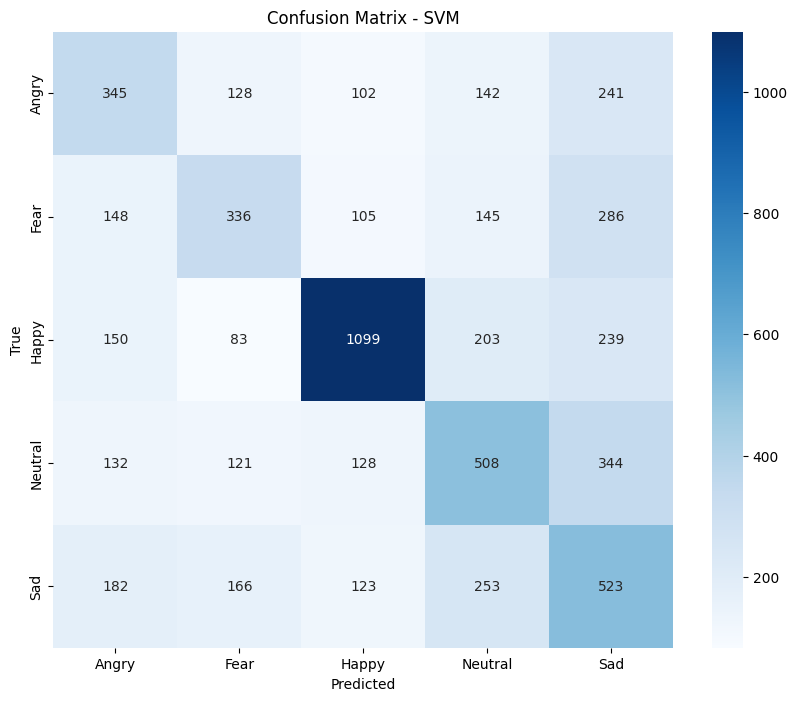

In [ ]:
# Convert the numeric labels back to text labels
index_to_label = {v: k for k, v in label_map.items()}
svm_pred_labels = [index_to_label[i] for i in svm_predictions]
svm_true_labels = [index_to_label[i] for i in testing_labels_numeric]

# Define a consistent order for the labels, which is in alphabetical order
label_order = sorted(list(label_map.keys()))
# This is for the confusion matrix. Reference: https://proclusacademy.com/blog/practical/confusion-matrix-accuracy-sklearn-seaborn/
cm_svm = confusion_matrix(svm_true_labels, svm_pred_labels, labels=label_order)

plt.figure(figsize = (10, 8))
sns.heatmap(cm_svm, annot = True,
            fmt = 'd',
            cmap = 'Blues',
            xticklabels = label_order,
            yticklabels = label_order)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SVM')
plt.show();

In [ ]:
# Show classification report
print("Classification report for SVM:")
print(classification_report(svm_true_labels, svm_pred_labels, target_names=label_order))

Classification report for SVM:
              precision    recall  f1-score   support

       Angry       0.36      0.36      0.36       958
        Fear       0.40      0.33      0.36      1020
       Happy       0.71      0.62      0.66      1774
     Neutral       0.41      0.41      0.41      1233
         Sad       0.32      0.42      0.36      1247

    accuracy                           0.45      6232
   macro avg       0.44      0.43      0.43      6232
weighted avg       0.47      0.45      0.46      6232



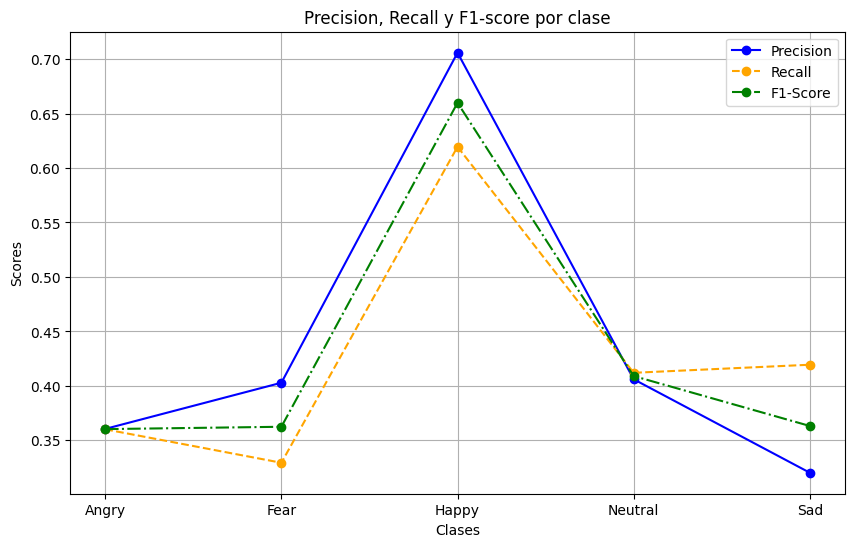

In [ ]:
# This is to calculate the corresponding metrics to determine the performance of the model
precision, recall, f1_score, _ = precision_recall_fscore_support(svm_true_labels, svm_pred_labels, labels=label_order)

# Reference: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
plt.figure(figsize = (10, 6))
plt.plot(label_order, precision, marker = 'o', label = 'Precision', linestyle = '-', color = 'blue')
plt.plot(label_order, recall, marker = 'o', label = 'Recall', linestyle = '--', color = 'orange')
plt.plot(label_order, f1_score, marker = 'o', label = 'F1-Score', linestyle = '-.', color = 'green')

plt.title('Precision, Recall y F1-score por clase')
plt.xlabel('Clases')
plt.ylabel('Scores')
plt.legend(loc = 'best')
plt.grid(True)

plt.show();